### **1.3 Sampling from Posterior Probability Distribution**

We learned in the last section how to derive posterior probability distributions for parameters we are interested in analyzing. We know a posterior distribution is the multiplication of the likelihood function and the prior distribution. Oftentimes, a posterior distribution formula is **too complicated to manipulate** or is in **high dimension**. Hence, <u> we have to conduct sampling </u> to obtain a series of **sample data points** from the **posterior distribution** to <u> investigate its **marginal distribution density**, mean, and other parameters. </u>

The most popular **sampling** method is the **Markov-Chain-Monte-Carlo (MCMC)** method. Monte Carlo is a random **sampling** method when the **samples are independent**. <u> Markov-Chains address random samples that are autocorrelated to each other. </u> Hence, <u> MCMC method is a random sampling method for autocorrelated samples. </u> There are several sampling algorithms under the MCMC method. The two most popular ones are the **Metropolis-Hastings algorithm** and the **Gibbs Sampling algorithm**. For those who are interested in the details of these algorithms, there are plenty of materials to explore online. For the following sections, the software (R) we are using to conduct Bayesian estimation on GARCH models uses the Metropolis-Hastings algorithm. 

One final note about sampling before we move on to Bayesian estimation of GARCH models: <u> The MCMC method is **sensitive** to the **initial values** used to start sampling. </u> Therefore, sometimes, we would use the <u> result from **maximum likelihood estimation** as the starting values </u> for Bayesian estimation. We will demonstrate this point when we show how to use Bayesian estimation in a later section.

## **2. Bayesian Estimation on GARCH Model**

In this section, we are going to go over the steps to use Bayesian method to fit a GARCH model. Specifically, we will focus on a GARCH model with Student's t innovations (errors). From the last lesson, we see that one common feature of financial asset returns is their heavy tail distribution. Hence, it is reasonable to use Student's t-distribution to model asset returns. 

Ardia and Hoogerheide (2010) demonstrated the steps using Bayesian estimation to fit a GARCH model with Student's t innovations. They wrote an R package (bayesGARCH) to automate the sampling process by using the Metropolis-Hastings algorithm. In the next section, we will use our Google stock return as an example to show the process. Before diving into the example, let's go over the theory for GARCH model with Student's t innovations first.

$$ \varepsilon_{t} = \sigma_t Z_{t} \sqrt{\frac{\nu-2}{\nu}\omega_{t}} $$ 

where 
> $t = 1, \cdots, T $ <br>
> $Z{t} \sim \text{iid normal} (0,1)$ <br>
> $ \omega_{t} \sim \text{iid inverse gamma} (\frac{\nu}{2}, \frac{\nu}{2})$ <br>
> $\sigma_{t}^{2} = \alpha_{0} + \alpha_{1} \varepsilon_{t-1}^{2} + \beta \sigma_{t-1}^{2} $ where $\alpha_{0} > 0, \ \alpha_{1}, \beta \ge 0$ and $\nu \gt 2$. <br>

Remember $\varepsilon_t = \sigma_t Z_t$ from **GARCH** model, this is just the **Student's T distribution** variant.

The restrictions above will ensure that the variance will be positive and finite. However, they do not ensure stationarity. We know from the last lesson that $\alpha_{1} + \beta < 1$ is needed to ensure stationary. We will use the result in our application later.

Another point we would like to explain is the inclusion of $\omega_{t}$. The reason we have $\omega_{t}$ as a prior multiplied with the variance of $\varepsilon_{t}$ in the model is that the marginal distribution of $\varepsilon_{t}$ will become a Student's t-distribution with degrees of freedom $\nu$.

The priors for $\alpha_{0}, \alpha_{1}, \beta$ are assumed to be truncated normal distributions with the domains greater than $0$ since these restrictions ensure positive and finite variance. The prior for $\nu$ is shifted exponential distribution. 

The joint posterior distribution will look like:

$$ p(\alpha_{0}, \alpha_{1}, \beta, \nu, \omega_{t} | \varepsilon_{t}) = \frac{l(\varepsilon_{t} | \alpha_{0}, \alpha_{1}, \beta, \nu, \omega_{t}) \ p(\alpha_{0}, \alpha_{1}, \beta, \nu, \omega_{t})}{p(\varepsilon_{t})} $$

Then, MCMC will <u> sample from the joint posterior distribution for each parameter. </u> From the sampled data, we can generate the **density** for each parameter. As we mentioned in the last section, MCMC sampling can be sensitive to initial values. One method to avoid extreme values from initial values is to drop the first $n$ numbers of sampled observations. This is called a **burn-in** period. We can indicate to the package how many initial sampled observations we would like to drop from our sample series. We will elaborate more on this topic in the next section.


In [ ]:
"""
The package pymc3 is DEPRECATED !
"""

# # First Round MCMC Sampling Result: Parameter Trace Plots and Marginal Density Plots

# # starting parameters = blank canvas model(0.000001, 0.000001, 0.000001)
# alpha_mu = shared(np.array([0.000001, 0.000001], dtype=np.float64))
# alpha_sigma = shared(np.array([[1000.0, 0.0], [0.0, 1000.0]], dtype=np.float64))

# beta_mu = shared(np.array(0.000001, dtype=np.float64))
# beta_sigma = shared(np.array(1000.0, dtype=np.float64))

# # initial volatility
# ivolatility = shared(np.array(0.000001, dtype=np.float64))
# ivolatility_vol = shared(np.array(10.0, dtype=np.float64))

# # construct MCMC model
# mcmc0 = pm.Model()

# with mcmc0:
#     # create multivariate normal: p(α) ∝ φN2(α|µα,Σα) 1 {α ∈ R^2+}
#     mvn = pm.MvNormal("mvNormal", mu=alpha_mu, cov=alpha_sigma, shape=2)

#     # restrict the two coefficients to be greater than zero
#     alp0 = pm.Deterministic("alpha0", pm.math.switch(mvn[0] > 0, mvn[0], -np.inf))
#     alp1 = pm.Deterministic("alpha1", pm.math.switch(mvn[1] > 0, mvn[1], -np.inf))

#     # create univariate truncated normal: p(β) ∝ φN1(β|µβ,Σβ) 1{β ∈ R+}
#     nTruncated = pm.TruncatedNormal("beta", mu=beta_mu, sigma=beta_sigma, lower=0)
#     volTruncated = pm.TruncatedNormal(
#         "volatility", mu=ivolatility, sigma=ivolatility_vol, lower=0
#     )

#     # likelihood
#     likelihood = GARCH11(
#         "GARCH",
#         omega=alp0,
#         alpha_1=alp1,
#         beta_1=nTruncated,
#         initial_vol=volTruncated,
#         observed=goog.GOOGLE_R.dropna() * 100,
#     )

# # Plot first round MCMC model posteriors
# with mcmc0:
#     step_mcmc0 = pm.Slice()
#     trace_mcmc0 = pm.sample(
#         2000,
#         cores=2,
#         step=step_mcmc0,
#         tune=0,  # tune=0 => no burn-in
#         return_inferencedata=False,
#         random_seed=12345,
#     )
#     az.plot_trace(
#         trace_mcmc0,
#         var_names=["alpha0", "alpha1", "beta"],
#         # plot vertical lines at GARCH(1,1) MLE param results
#         lines=[
#             ("alpha0", {}, [0.124993]),
#             ("alpha1", {}, [0.082160]),
#             ("beta", {}, [0.867127]),
#         ],
#         compact=False,
#         legend=True,
#         figsize=(16, 7),
#     )
#     plt.tight_layout()
#     plt.show()

**Figure 1: First Round MCMC Sampling Result: Parameter Trace Plots and Marginal Density Plots**


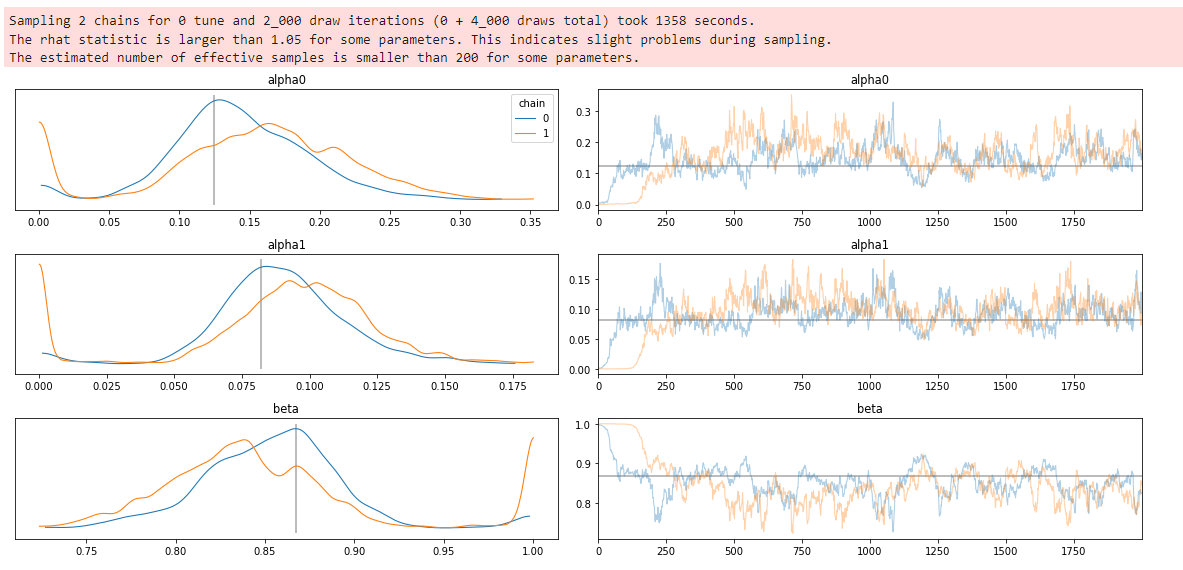

On the right of figure 1 are the plots called trace plots for parameters. Let's focus on the trace plot of *alpha0* for now to learn how to read the plot. There are two series on the trace plot. One is blue and the other is orange. They represent the two chains sampled from MCMC. Let's focus on the blue one first. The trace plot lays out the way that the first sampled data is on the leftmost side of the plot, and the second sampled data follows it to the right and so on and so forth. We can see that the first 300 samples start with very volatile movement. As more and more sampled data is collected, the series starts to converge to a value of around $0.12$. However, there is some volatility between the 500th sample and 100th sample. The orange chain in general demonstrates a pattern similar to the blue chain. Let's run the summary test to see how well the MCMC sample converges.

In [ ]:
"""
pymc3 is deprecated.
"""

# # First Round MCMC Convergence Test Result and Parameter Estimations
# az.summary(trace_mcmc0, round_to=7).loc[["alpha0", "alpha1", "beta"], :]

**Figure 2: First Round MCMC Convergence Test Result and Parameter Estimations**


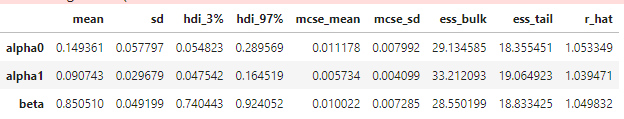

Last column in Figure 2 for *r_hat* represents the **Gelman-Rubin statistic**. It tests for **lack of convergence** by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. <u> If *r_hat* < 1.2 for all model parameters, we can have some confidence that convergence has been reached. </u>

Let's look at the estimations for the parameters. Figure 2 shows the estimated parameters from the first round MCMC sampling result. Let's focus on the means of the coefficients. We see *alpha0*, *alpha1* and *beta* all look reasonable within our restrictions for stationary and positive and finite variance. But so far the model represents so called 'blank canvas' model i.e. <u> we have not accounted for any meaningful starting values. </u> In this initial model the starting values are all **near zero** for all *alpha0*, *alpha1* and *beta* priors. 

We discussed in the previous section that the MCMC **can be sensitive to starting value**. If starting value is way off, it can impact the final result of MCMC. In this case, we can assign starting values to parameters before the MCMC starts sampling. In that way, we restrain MCMC from going wild when sampling. So where can we find initial values for parameters? In the previous lesson, we estimated the parameters using **maximum likelihood**. We can use these estimates as starting values for MCMC. Otherwise, this step is a trial-and-error process. You might need to run MCMC a number of times for MCMC to converge to a solution and find reasonable coefficient estimates. 

For the next round of MCMC, we adjust starting values for parameters in the code and rerun MCMC. The following figures show the final results of the second run MCMC sampling.

In [ ]:
# # Second Round MCMC Sampling Result: Parameter Trace Plots and Marginal Density Plots

# # starting parameters = MLE(0.124993, 0.082160, 0.867127)
# alpha_mu = shared(np.array([0.124993, 0.082160], dtype=np.float64))
# alpha_sigma = shared(np.array([[1000.0, 0.0], [0.0, 1000.0]], dtype=np.float64))

# beta_mu = shared(np.array(0.867127, dtype=np.float64))
# beta_sigma = shared(np.array(1000.0, dtype=np.float64))

# # initial volatility
# ivolatility = shared(
#     np.array(1.63865, dtype=np.float64)
# )  # np.std(goog["GOOGLE_R"].dropna()*100)
# ivolatility_vol = shared(np.array(10.0, dtype=np.float64))

# # construct MCMC model
# mcmc = pm.Model()

# with mcmc:
#     # create a multivariate normal: p(α) ∝ φN2(α|µα,Σα) 1 {α ∈ R^2+}
#     mvn = pm.MvNormal("mvNormal", mu=alpha_mu, cov=alpha_sigma, shape=2)

#     # restrict the two coefficients to be greater than zero
#     alp0 = pm.Deterministic("alpha0", pm.math.switch(mvn[0] > 0, mvn[0], -np.inf))
#     alp1 = pm.Deterministic("alpha1", pm.math.switch(mvn[1] > 0, mvn[1], -np.inf))

#     # create univariate truncated normal: p(β) ∝ φN1(β|µβ,Σβ) 1{β ∈ R+}
#     nTruncated = pm.TruncatedNormal("beta", mu=beta_mu, sigma=beta_sigma, lower=0)
#     volTruncated = pm.TruncatedNormal(
#         "volatility", mu=ivolatility, sigma=ivolatility_vol, lower=0
#     )

#     # likelihood
#     likelihood = GARCH11(
#         "garch",
#         omega=alp0,
#         alpha_1=alp1,
#         beta_1=nTruncated,
#         initial_vol=volTruncated,
#         observed=goog.GOOGLE_R.dropna() * 100,
#     )

# # Plot Second round MCMC model posteriors
# with mcmc:
#     step_mmc = pm.Slice()
#     trace_mmc = pm.sample(
#         2000,
#         cores=2,
#         step=step_mmc,
#         tune=0,  # no burn-in
#         return_inferencedata=False,
#         random_seed=12345,
#     )
#     az.plot_trace(
#         trace_mmc,
#         var_names=["alpha0", "alpha1", "beta"],
#         lines=[
#             ("alpha0", {}, [0.124993]),
#             ("alpha1", {}, [0.082160]),
#             ("beta", {}, [0.867127]),
#         ],
#         compact=False,
#         legend=True,
#         figsize=(16, 7),
#     )
#     plt.tight_layout()
#     plt.show()

**Figure 3: Second Round MCMC Sampling Result: Parameter Trace Plots and Marginal Density Plots**


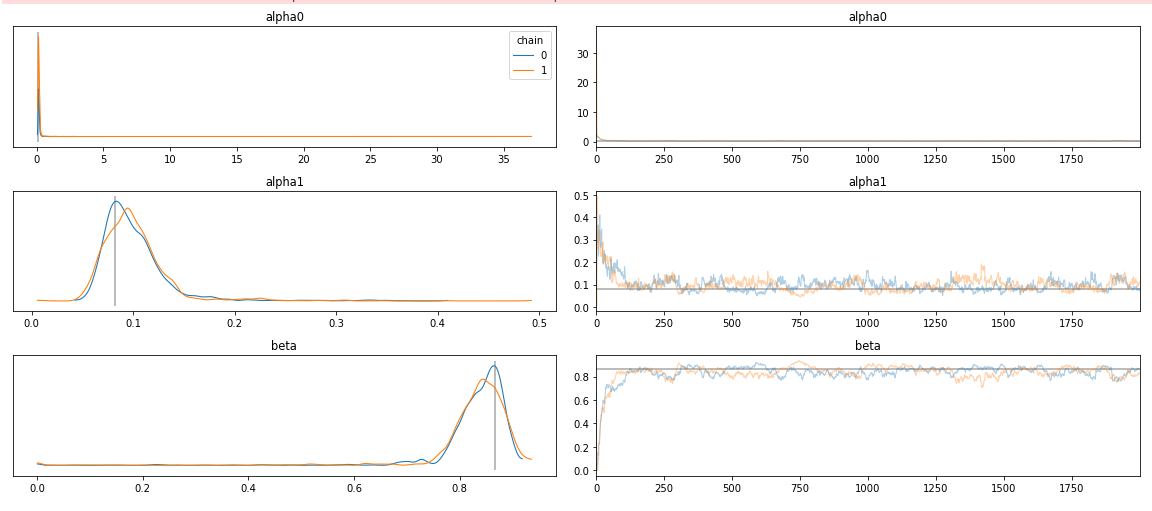

In figure 3, we can see that after adding starting values to the code, the trace plot for all priors converges better in this round of MCMC. Let's check the Gelman-Rubin convergence test and other parameter estimations.


In [ ]:
# # Second Round MCMC Sampling Result: Parameter estimation
# az.summary(trace_mmc, round_to=7).loc[["alpha0", "alpha1", "beta"], :]

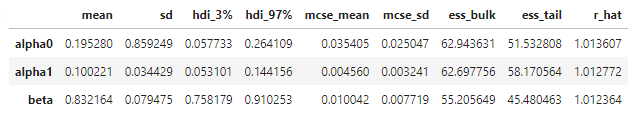

We can see from figure 4 that all the parameters have converged pretty well after adding starting values to the code and *r_hat* improved.

However, we can still see from figure 3 that the first 250 data points seem to be **very volatile**. We can treat them as the **burn-in** period and drop those sampled data points. At this point, we will also combine chains. Let's check out the MCMC result after these steps.

In [ ]:
# # Second Round MCMC Sampling Result: Parameter Trace Plots and Density Plots After Adjustment
# with mcmc:
#     step_mmc_a = pm.Slice()
#     trace_mmc_a = pm.sample(
#         2000,
#         cores=2,
#         step=step_mmc_a,
#         tune=250,  # burn-in = 250 steps
#         return_inferencedata=False,
#         random_seed=12345,
#     )
#     az.plot_trace(
#         trace_mmc_a,
#         var_names=["alpha0", "alpha1", "beta"],
#         lines=[
#             ("alpha0", {}, [0.124993]),
#             ("alpha1", {}, [0.082160]),
#             ("beta", {}, [0.867127]),
#         ],
#         combined=True,  # to combine chains in one line
#         compact=False,
#         legend=True,
#         figsize=(16, 7),
#     )
#     plt.tight_layout()
#     plt.show()

**Figure 5: Second Round MCMC Sampling Result: Parameter Trace Plots and Density Plots After Adjustment**

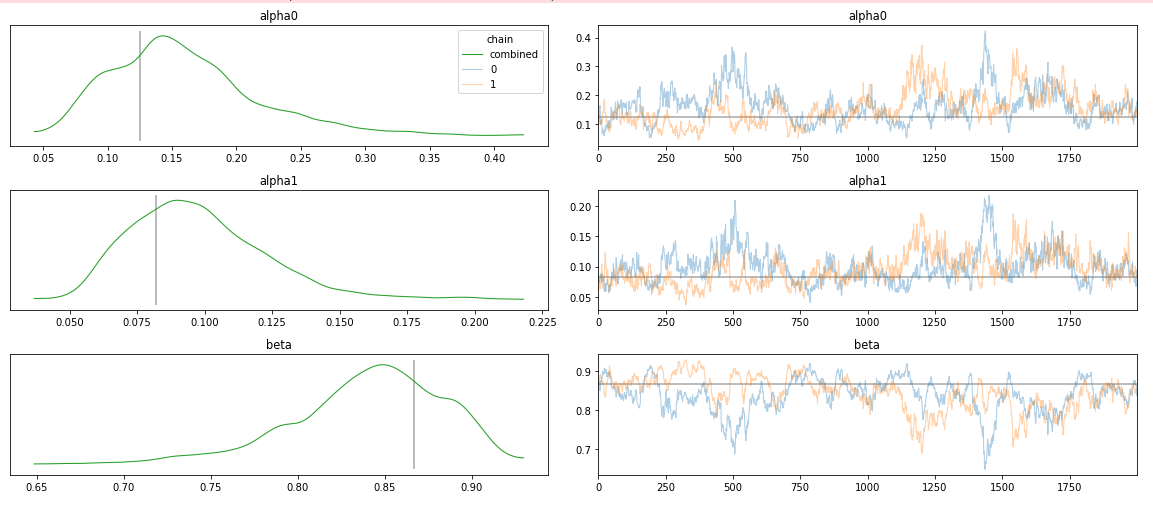

From figure 5, we can see we only have one series in each plot now as we have combined chain 1 and chain 2. The trace plots all seem to oscillate within a range and show no trends. On the left, we can see that the marginal densities of *alpha0* and *alpha1* seem to skew to the right while the marginal density for beta skew to the left. Let's check the final parameter estimates.


In [ ]:
# # First Round MCMC Sampling Result: Parameter Estimation with Adjustment
# az.summary(trace_mmc_a, round_to=7).loc[["alpha0", "alpha1", "beta"], :]

**Figure 6: First Round MCMC Sampling Result: Parameter Estimation with Adjustment**


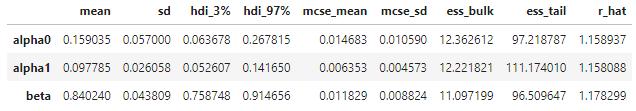

In figure 6, we can see that all estimated coefficients are well behaved and confined in the restrictions to meet stationarity and positive and finite variance requirements. In figure 7 below, we can compare the estimated coefficients from MLE and Bayesian estimations. We can see the estimated coefficients are similar. <u> We achieved this comparable result partly because we used MLE estimates as our starting values for MCMC sampling. </u> By **carefully selecting starting values for MCMC**, we can control the behavior of the estimated coefficients.

**Figure 7: Google Stock Return, GARCH Model Estimated Parameters Comparison Between MLE and Bayesian**

|              | MLE(norm) | MLE(st) | Bayesian |
| :---:        |      ---: |    ---: |     ---: |
| omega/alpha0 |   0.1250  |  0.0616 |  0.1590  |
| alpha1       |   0.0822  |  0.1039 |  0.0978  |
| beta         |   0.8671  |  0.8865 |  0.8402  |
